In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:

# grid search ARIMA parameters for time series
import math  
import warnings
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

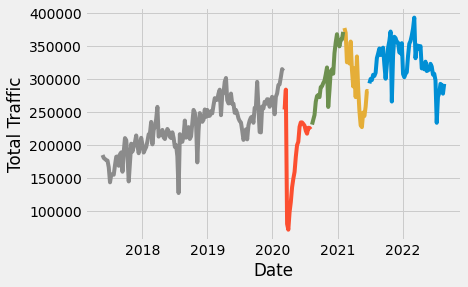

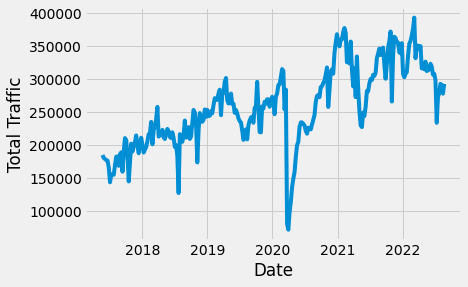

In [7]:
# Import the dataframe
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Road Toll/Train.csv')
test1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Road Toll/Test 1.csv')
test2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Road Toll/Test 2.csv')
omit1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Road Toll/Omit1.csv')
omit2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Road Toll/Omit2.csv')
totaltraffic = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Road Toll/TotalTraffic.csv')




# Convert date column to datetime
train['Date'] = pd.to_datetime(train['Date'])
test1['Date'] = pd.to_datetime(test1['Date'])
test2['Date'] = pd.to_datetime(test2['Date'])
omit1['Date'] = pd.to_datetime(omit1['Date'])
omit2['Date'] = pd.to_datetime(omit2['Date'])
totaltraffic['Date'] = pd.to_datetime(totaltraffic['Date'])


train.index = train['Date']
test1.index = test1['Date']
test2.index = test2['Date']
omit1.index = omit1['Date']
omit2.index = omit2['Date']
totaltraffic.index = totaltraffic['Date']



del train['Date']
del test1['Date']
del test2['Date']
del omit1['Date']
del omit2['Date']
del totaltraffic['Date']


#Covert Traffic column from strin to float
train['Traffic'] = train['Traffic'].astype(float)
test1['Traffic'] = test1['Traffic'].astype(float)
test2['Traffic'] = test2['Traffic'].astype(float)
omit1['Traffic'] = omit1['Traffic'].astype(float)
omit2['Traffic'] = omit2['Traffic'].astype(float)
totaltraffic['Traffic'] = totaltraffic['Traffic'].astype(float)


plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.plot(test2)
plt.plot(omit1)
plt.plot(omit2)
plt.plot(test1)
plt.plot(train)
plt.show()

plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.plot(totaltraffic)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                       SARIMAX Results                                       
Dep. Variable:                               Traffic   No. Observations:                  146
Model:             SARIMAX(11, 1, 12)x(0, 1, [], 52)   Log Likelihood                -899.244
Date:                               Mon, 26 Sep 2022   AIC                           1846.488
Time:                                       05:08:17   BIC                           1903.657
Sample:                                   05-22-2017   HQIC                          1869.409
                                        - 03-02-2020                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4047      4.827     -0.084      0.933      -9.866       9.056
ar.L2      

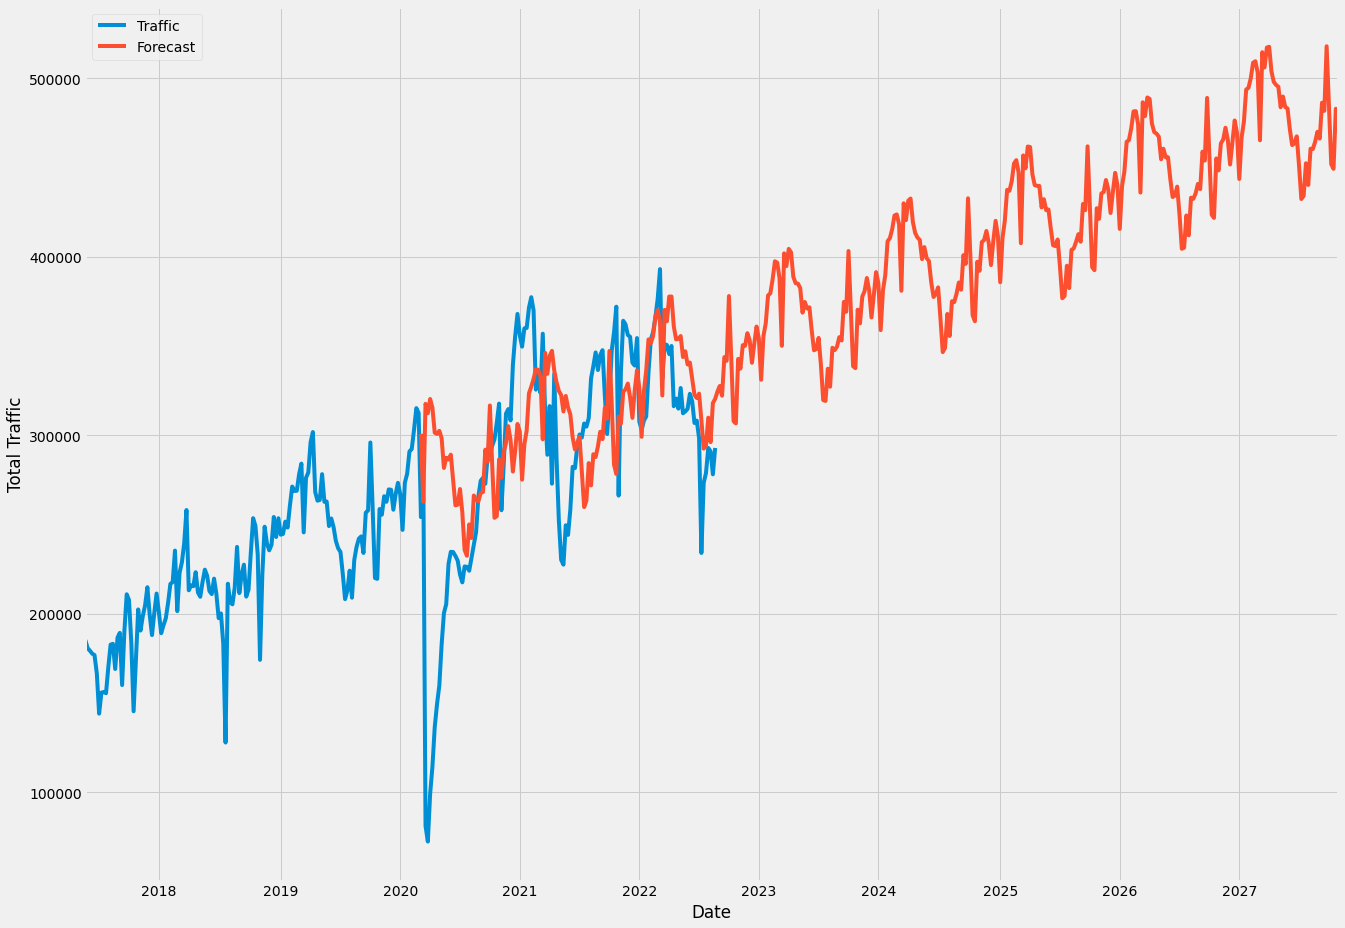


RMSE : 35238.839185543395

MAPE : 0.08924069546402387


In [8]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(11, 1, 12),
                                seasonal_order=(0, 1, 0, 52),
                                trend="n",
                                enforce_stationarity=False,
                                enforce_invertibility=False)



results = mod.fit()

# #timer
# end = datetime.datetime.now()
# print("\nEnd time: ", end, "\n")

print(results.summary())

# Get forecast 400 steps ahead in future
pred_uc = results.get_forecast(steps=400)




# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = totaltraffic.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Total Traffic')

plt.legend()
plt.show()

pred_uc.predicted_mean.to_csv('/content/gdrive/My Drive/Colab Notebooks/Road Toll/Results/forecast_Total_Traffic_pcu(11,1,12)(0,1,0).csv')

# plt.plot(train)
# plt.plot(test1)
# plt.plot(test2)
# plt.plot(omit)
# plt.plot(pred_uc.predicted_mean, color='magenta')

# ax.set_xlabel('Date')
# ax.set_ylabel('Total Traffic')

# plt.legend()
# plt.show()

#Calculate MAPE

predict = pd.DataFrame(pred_uc.predicted_mean)
predict["Date"] = (predict.index).to_pydatetime()

split_date_one = datetime.datetime(2020,8,10)
split_date_two = datetime.datetime(2021,2,7)
forecastperiod1 = predict[(predict["Date"] >= split_date_one) & (predict["Date"] <= split_date_two)]

split_date_three = datetime.datetime(2021,6,28)
split_date_four = datetime.datetime(2022,8,22)
forecastperiod2 = predict[(predict["Date"] >= split_date_three) & (predict["Date"] <= split_date_four)]

forecast_p1andp2 = pd.concat([forecastperiod1["predicted_mean"], forecastperiod2["predicted_mean"]])
test_p1and2 = pd.concat([test1["Traffic"], test2["Traffic"]])



rmse = sqrt(mean_squared_error(test_p1and2, forecast_p1andp2))
mape = mean_absolute_percentage_error(test_p1and2, forecast_p1andp2)



print("\nRMSE :",rmse)
print("\nMAPE :",mape)